# Startup Prediction with Y combinator Dataset


In [1]:
import os
import json
import joblib
import kagglehub

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Import dataset from Kaggle

In [15]:
# download the dataset from kaggle and set the path for the downloaded file
path = kagglehub.dataset_download("sashakorovkina/ycombinator-all-funded-companies-dataset")

Initialize all the csv files exported form the dataset

In [3]:
# list all the filenames for csv files in dataset to read the csv and declare variable for clean dataframes
file_names = [
    'companies.csv', 'industries.csv', 'schools.csv', 'badges.csv',
    'regions.csv', 'tags.csv', 'prior_companies.csv', 'founders.csv'
]
cleaned_dataframes = {}

Read the csv files, clean it and save it in a above declared object

In [4]:
# loop through the above declared filenames and read each csv.
for file_name in file_names:
    df = pd.read_csv(os.path.join(path, file_name)).drop(
        columns=[col for col in pd.read_csv(os.path.join(path, file_name)).columns if 'Unnamed' in col]
    )
    # drop values if empty
    df_cleaned = df.dropna() if df.isnull().values.any() else df

    # map clean data for each csv with their file_name
    cleaned_dataframes[file_name.split('.')[0]] = df_cleaned

    # check rows and columns for each dataframe
    print(f"{file_name.split('.')[0]}: {df_cleaned.shape}")

companies: (3848, 11)
industries: (8838, 2)
schools: (46253, 4)
badges: (2641, 2)
regions: (4521, 4)
tags: (12969, 2)
prior_companies: (32610, 2)
founders: (2200, 8)


In [5]:
# Merge company-related dataframes based on id
company_info = cleaned_dataframes['companies'][['id', 'name', 'teamSize', 'slug', 'status']]
company_info = company_info.merge( cleaned_dataframes['industries'][['id', 'industry']], on='id', how='left').merge(cleaned_dataframes['badges'][['id', 'badge']], on='id', how='left').merge(cleaned_dataframes['tags'][['id', 'tag']], on='id', how='left').merge( cleaned_dataframes['regions'][['id', 'region', 'country']], on='id', how='left')

# Merge founder-related dataframes based on hnid
founder_info = cleaned_dataframes['founders'][['hnid', 'first_name', 'last_name', 'current_company', 'top_company', 'company_slug']]
founder_info = founder_info.merge(cleaned_dataframes['schools'][['hnid', 'school', 'field_of_study']], on='hnid', how='left').merge( cleaned_dataframes['prior_companies'][['hnid', 'company']], on='hnid', how='left')

# Merge company and founder deataframes based upon company_slug
merged_df = company_info.merge( founder_info, left_on='slug', right_on='company_slug', how='left')

# Keep only relevant columns
merged_df = merged_df[['id', 'hnid', 'name', 'teamSize', 'industry', 'school', 'field_of_study', 'badge', 'region', 'country', 'company','first_name', 'last_name', 'current_company', 'top_company', 'tag', 'status']]

# Remove rows with missing values
merged_df = merged_df.dropna()

print("\nMissing values in final dataset:")
print(merged_df.isnull().sum())


Missing values in final dataset:
id                 0
hnid               0
name               0
teamSize           0
industry           0
school             0
field_of_study     0
badge              0
region             0
country            0
company            0
first_name         0
last_name          0
current_company    0
top_company        0
tag                0
status             0
dtype: int64


Extract the top 10 schools, industries, field of study, region, prior company and tag for computation

In [6]:
# identify the top 10 schools, industry, field of study, region, prior comapny, tag
count = 10
top_schools = merged_df['school'].value_counts().head(count).index.tolist()
top_industry = merged_df['industry'].value_counts().head(count).index.tolist()
top_field_of_study = merged_df['field_of_study'].value_counts().head(count).index.tolist()
top_region = merged_df['region'].value_counts().head(count).index.tolist()
top_prior_company = merged_df['company'].value_counts().head(count).index.tolist()
top_tag = merged_df['tag'].value_counts().head(15).index.tolist()

Group all datasets based upon Name of Company

In [7]:
# group the merged dataframe accorading to name, if multiple values create unique list, mean value for team size, and set first values for single data
grouped_by_company_name_df = merged_df.groupby('name', sort=False).agg(
    teamSize=('teamSize', 'mean'),
    industry=('industry', lambda x: list(x.unique())),
    school=('school', lambda x: list(x.unique())),
    field_of_study=('field_of_study', lambda x: list(x.unique())),
    badge=('badge', lambda x: list(x.unique())),
    region=('region', 'first'),
    country=('country', 'first'),
    company=('company', lambda x: list(x.unique())),
    current_company=('current_company', lambda x: list(x.unique())),
    tag=('tag', lambda x: list(x.unique())),
    top_company=('top_company', 'first'),
    status=('status', 'first'),
).reset_index()

grouped_by_company_name_df.head()

,name,teamSize,industry,school,field_of_study,badge,region,country,company,current_company,tag,top_company,status
0,Reddit,2000.0,"[Consumer, Content]",[University of Virginia],[History],[topCompany],America / Canada,United States of America,"[Initialized Capital, Y Combinator, Hipmunk, R...",[Initialized Capital],"[Community, Social Media, Social, Social Network]",True,Acquired
1,Machine Zone,501.0,"[Consumer, Gaming]","[University of California, Berkeley]",[Applied Mathematics In Computer Science],[topCompany],America / Canada,United States of America,"[Machine Zone, Global VR, Signature Devices]",[Machine Zone],[Gaming],True,Acquired
2,Airbnb,6132.0,"[Consumer, Travel, Leisure and Tourism]",[Harvard University],[Computer Science],[topCompany],America / Canada,United States of America,"[Airbnb, Consult Mavens, Batiq, OPNET Technolo...",[Airbnb],"[Marketplace, Travel]",True,Public
3,PagerDuty,950.0,"[B2B, Engineering, Product and Design]","[University of Waterloo, University of Toronto]","[Software Engineering, Computer Science, Compu...",[topCompany],America / Canada,United States of America,"[Y Combinator, s28 Capital, Amazon, PagerDuty,...","[Y Combinator, BorgIQ]","[DevOps, Monitoring]",True,Public
4,Presto,200.0,"[B2B, Retail]",[University of Waterloo],[Engineering],[topCompany],America / Canada,United States of America,"[Presto, Lyft, FedS, Forum for Independent Tho...",[Presto],"[Food Service Robots & Machines, Restaurant Tech]",True,Public


Initialize new columns

In [8]:
# create new columns in the dataframe
# for list data, if any item is matched in top 10 list for that category of data, set 1 else 0
def preprocess_data_with_top_features(data, top_schools, top_industry, top_field_of_study, top_region, top_prior_company, top_tag):
    data['top_school'] = data['school'].apply(lambda x: 1 if any(item in top_schools for item in x) else 0)

    data['top_region'] = data['region'].apply(lambda x: 1 if x in top_region else 0)

    data['top_industry'] = data['industry'].apply(lambda x: 1 if any(item in top_industry for item in x) else 0)

    data['top_field_of_study'] = data['field_of_study'].apply(lambda x: 1 if any(item in top_field_of_study for item in x) else 0)

    data['top_prior_company'] = data['company'].apply(lambda x: 1 if any(item in top_prior_company for item in x) else 0)

    data['top_tag'] = data['tag'].apply(lambda x: 1 if any(item in top_tag for item in x) else 0)

    data['teamSize'] = data['teamSize'].astype(int)

    data['success_status'] = data['status'].apply(lambda x: 1 if x in ['Acquired', 'Public'] else 0)

    data.drop(columns=['industry', 'school', 'field_of_study', 'badge', 'current_company', 'company', 'tag', 'country', 'region', 'teamSize', 'status'], inplace=True)

    return data

processed_data = preprocess_data_with_top_features(
    grouped_by_company_name_df,
    top_schools,
    top_industry,
    top_field_of_study,
    top_region,
    top_prior_company,
    top_tag
)

processed_data.head()

,name,top_company,top_school,top_region,top_industry,top_field_of_study,top_prior_company,top_tag,success_status
0,Reddit,True,0,1,1,0,1,0,1
1,Machine Zone,True,1,1,1,0,0,0,1
2,Airbnb,True,1,1,1,1,0,1,1
3,PagerDuty,True,0,1,1,1,1,0,1
4,Presto,True,0,1,1,0,0,0,1


In [9]:
# basic understanding for each columns in dataframe
processed_data.describe()

,top_school,top_region,top_industry,top_field_of_study,top_prior_company,top_tag,success_status
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,0.321429,0.953297,0.950549,0.472527,0.131868,0.755495,0.162088
std,0.467668,0.211293,0.217105,0.499932,0.338813,0.430385,0.369039
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Heatmap

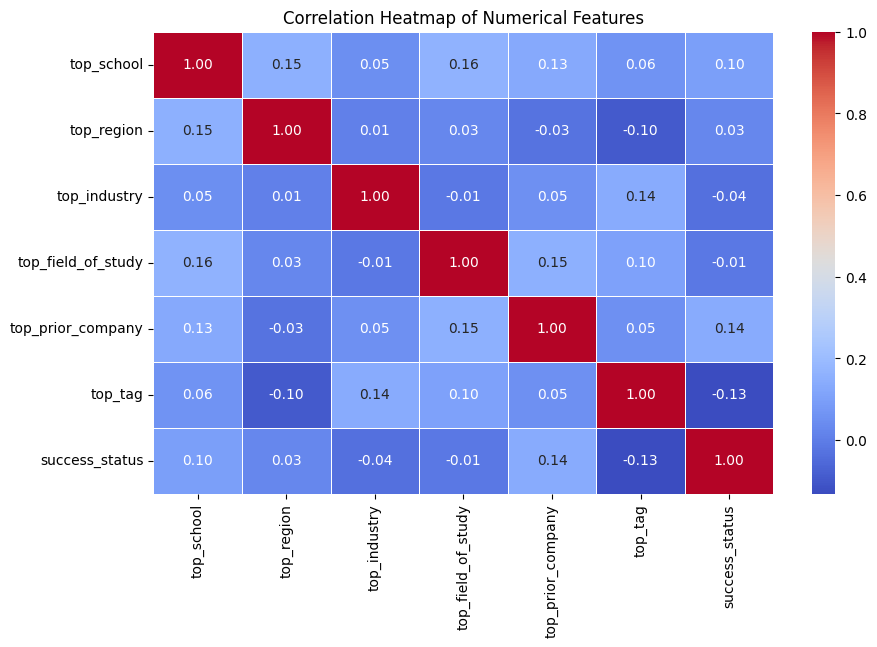

In [10]:
# Seperate numerical value and create a heatmap for each value and compare data for success_status
numerical_cols = processed_data.select_dtypes(include=['int64', 'float64']).columns
numerical_data = processed_data[numerical_cols]
corr_matrix = numerical_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Box Plot

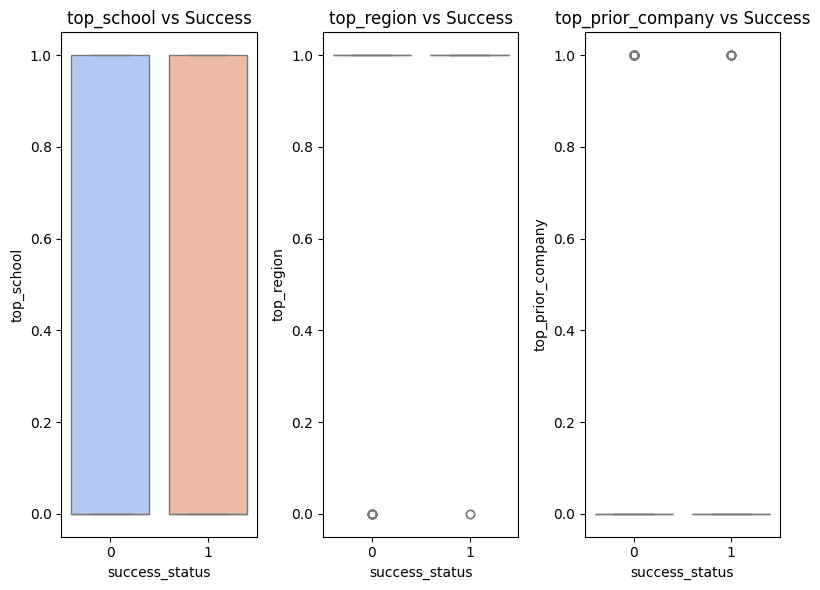

In [11]:
# create box plot to compare more likely datas against success_status
columns_to_plot = ['top_school', 'top_region', 'top_prior_company']

plt.figure(figsize=(8, 6))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(1,3, i)
    sns.boxplot(x='success_status', y=col, data=processed_data, hue='success_status', palette='coolwarm', legend=False)
    plt.title(f'{col} vs Success')

plt.tight_layout()
plt.show()

Seperate test and train data

In [12]:
# remove less likely related data for prediction
df = processed_data.drop(columns=['name', 'top_industry', 'top_field_of_study', 'top_tag'])

# update the calue for top company in int format
df['top_company'] = df['top_company'].map({True: 1, False: 0})

# set x and y parameters for train test split
X = df.drop(columns=['success_status'])
y = df['success_status']

# breakdown dataset into 70-30 percentage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train and Test models based upon accuracy, precison, recall and f1 score

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.80      0.99      0.88        87
           1       0.50      0.04      0.08        23

    accuracy                           0.79       110
   macro avg       0.65      0.52      0.48       110
weighted avg       0.73      0.79      0.71       110



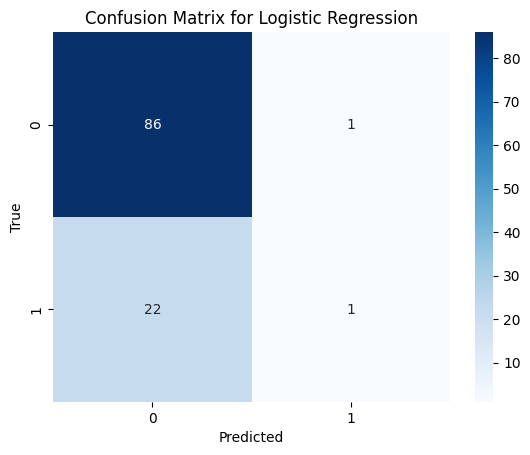

Classification Report for SVC:

              precision    recall  f1-score   support

           0       0.83      0.97      0.89        87
           1       0.67      0.26      0.38        23

    accuracy                           0.82       110
   macro avg       0.75      0.61      0.63       110
weighted avg       0.80      0.82      0.79       110



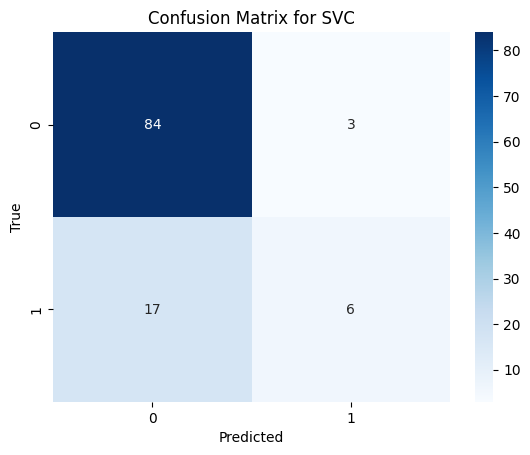

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.84      0.95      0.89        87
           1       0.64      0.30      0.41        23

    accuracy                           0.82       110
   macro avg       0.74      0.63      0.65       110
weighted avg       0.80      0.82      0.79       110



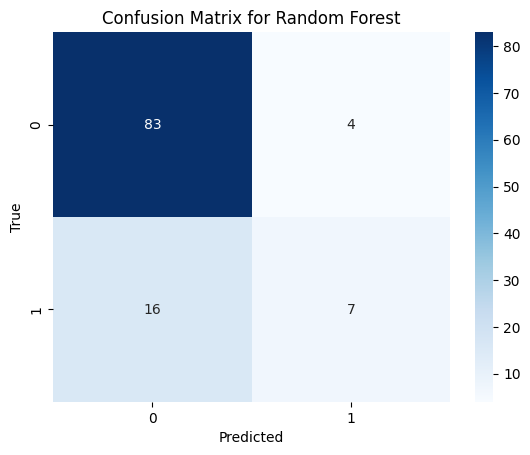

Classification Report for Gaussian Naive Bayes:

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        87
           1       0.55      0.52      0.53        23

    accuracy                           0.81       110
   macro avg       0.71      0.70      0.71       110
weighted avg       0.81      0.81      0.81       110



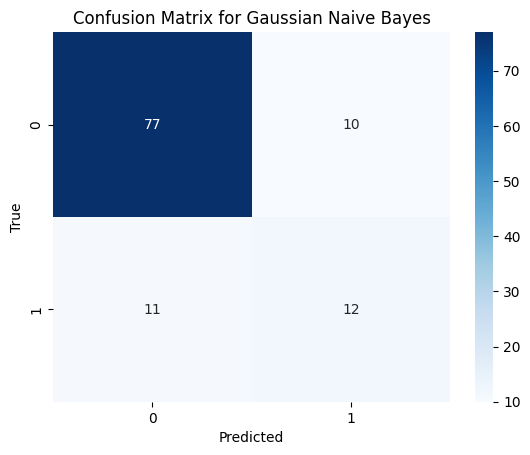

In [13]:
# set different classification models for prediciton
models = {
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gaussian Naive Bayes': GaussianNB()
}


for model_name, model in models.items():
    # train the model using training dataset
    model.fit(X_train_scaled, y_train)

    # test teh model with test dataset
    y_pred = model.predict(X_test_scaled)

    # calculate accuracy, precision, recall and f1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)

    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # create confusion matrix for each prediction model to analyse true positive and false positives
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


Save the generated model

In [14]:
# create directory to save the generated models
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

#save models
for model_name, model in models.items():
    file_path = f'saved_models/{model_name.replace(" ", "_")}.pkl'
    joblib.dump(model, file_path)
    print(f"{model_name} saved to {file_path}")

metrics = {}

#save metrics
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    metrics[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=1),
        'recall': recall_score(y_test, y_pred, zero_division=1),
        'f1_score': f1_score(y_test, y_pred, zero_division=1)
    }

with open('saved_models/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

#save confusion matrix
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.savefig(f'saved_models/{model_name.replace(" ", "_")}_confusion_matrix.png')
    plt.close()

Logistic Regression saved to saved_models/Logistic_Regression.pkl
SVC saved to saved_models/SVC.pkl
Random Forest saved to saved_models/Random_Forest.pkl
Gaussian Naive Bayes saved to saved_models/Gaussian_Naive_Bayes.pkl
